In [21]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score,confusion_matrix, precision_recall_curve,average_precision_score
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier

In [5]:
BASE_PATH = Path(r"C:/Users/nurs/PycharmProjects/pythonProject5/.ipynb_checkpoints/data/processed")
preprocessor = joblib.load(BASE_PATH / "lr_preprocessor.joblib")
X_train, X_test, y_train, y_test = joblib.load(BASE_PATH / "lr_data_split.joblib")

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((5625, 23), (1407, 23), (5625,), (1407,))

In [8]:
def evaluate_classifier(
    model,
    X_test,
    y_test,
    threshold=0.5,
    model_name=None
):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= threshold).astype(int)
    roc_auc = roc_auc_score(y_test, y_proba)
    f1      = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    title = "Confusion Matrix"
    if model_name:
        title += f" — {model_name}"
    title += f"\nThreshold = {threshold}"
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return {
        "roc_auc": roc_auc,
        "f1": f1,
        "confusion_matrix": cm
    }

In [10]:
lr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", LogisticRegression(
            max_iter=1000,
            solver="lbfgs",
            n_jobs=-1,
            random_state=42
        ))
    ]
)
lr_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


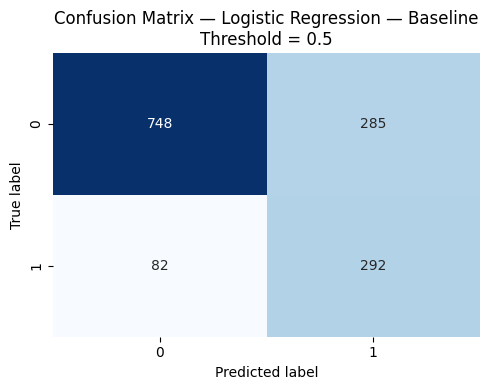

{'roc_auc': 0.8357413897531204,
 'f1': 0.6140904311251314,
 'confusion_matrix': array([[748, 285],
        [ 82, 292]])}

In [11]:
metrics_lr = evaluate_classifier(
    model=lr_pipeline,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression — Baseline"
)
metrics_lr

In [ ]:
tree_preprocessor = joblib.load(BASE_PATH / "tree_preprocessor.joblib")
X_train_dt, X_test_dt, y_train_dt, y_test_dt = joblib.load(
    BASE_PATH / "tree_data_split.joblib"
)

In [13]:
X_train_dt.shape, X_test_dt.shape, y_train_dt.shape, y_test_dt.shape

((5625, 23), (1407, 23), (5625,), (1407,))

In [14]:
y_train_dt.mean(), y_test_dt.mean()

(np.float64(0.2657777777777778), np.float64(0.2658137882018479))

In [17]:
dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", tree_preprocessor),
        ("model", DecisionTreeClassifier(
            max_depth=6,
            min_samples_leaf=50,
            class_weight="balanced",
            random_state=42
        ))
    ]
)
dt_pipeline.fit(X_train_dt, y_train_dt)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


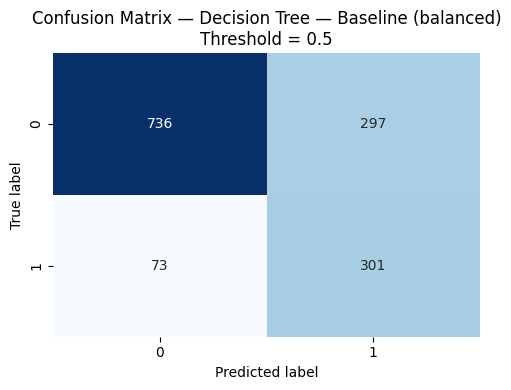

{'roc_auc': 0.8290711338658495,
 'f1': 0.6193415637860082,
 'confusion_matrix': array([[736, 297],
        [ 73, 301]])}

In [18]:
metrics_dt = evaluate_classifier(
    model=dt_pipeline,
    X_test=X_test_dt,
    y_test=y_test_dt,
    model_name="Decision Tree — Baseline (balanced)"
)
metrics_dt


In [20]:
metrics_lr = {
    "roc_auc": 0.8357,
    "f1": 0.6141
}
metrics_dt = {
    "roc_auc": 0.8291,
    "f1": 0.6193
}
baseline_results = pd.DataFrame([
    {
        "Model": "Logistic Regression (Baseline)",
        "ROC-AUC": metrics_lr["roc_auc"],
        "F1-score": metrics_lr["f1"]
    },
    {
        "Model": "Decision Tree (Baseline)",
        "ROC-AUC": metrics_dt["roc_auc"],
        "F1-score": metrics_dt["f1"]
    }
])

baseline_results

,Model,ROC-AUC,F1-score
0,Logistic Regression (Baseline),0.8357,0.6141
1,Decision Tree (Baseline),0.8291,0.6193


In [22]:
def plot_pr_curve(models, X_test, y_test, title="Precision-Recall Curve"):
    plt.figure(figsize=(7, 6))

    for name, model in models.items():
        y_scores = model.predict_proba(X_test)[:, 1]

        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        ap = average_precision_score(y_test, y_scores)

        plt.plot(
            recall,
            precision,
            linewidth=2,
            label=f"{name} (AP={ap:.3f})"
        )

    # baseline (random classifier)
    positive_rate = y_test.mean()
    plt.hlines(
        y=positive_rate,
        xmin=0,
        xmax=1,
        linestyles="dashed",
        colors="gray",
        label=f"Baseline (Churn rate={positive_rate:.2f})"
    )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

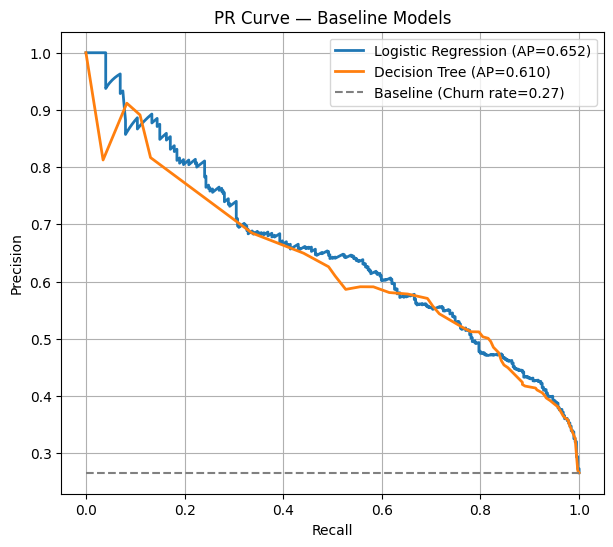

In [23]:
models_pr = {
    "Logistic Regression": lr_pipeline,
    "Decision Tree": dt_pipeline
}
plot_pr_curve(
    models=models_pr,
    X_test=X_test_dt,   # тот же test split
    y_test=y_test_dt,
    title="PR Curve — Baseline Models"
)

In [24]:
MODELS_PATH = Path("models/baseline")
MODELS_PATH.mkdir(parents=True, exist_ok=True)

In [25]:
joblib.dump(lr_pipeline, MODELS_PATH / "logistic_regression_baseline.joblib")
joblib.dump(dt_pipeline, MODELS_PATH / "decision_tree_baseline.joblib")


['models\\baseline\\decision_tree_baseline.joblib']

In [ ]:
joblib.dump(lr_pipeline, MODELS_PATH / "logistic_regression_baseline.joblib")
joblib.dump(dt_pipeline, MODELS_PATH / "decision_tree_baseline.joblib")